# Transformer Implementation

In order to master the transformers, I decided to implement the model from the research paper ["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf).

In [ ]:
#Import
import tensorflow as tf
import numpy as np

##Preprocessing

The inputs and outputs to Deep Learning models (including Transformers) are usually tensors of numbers where each numbers corresponds to a word.

example : {1: '<OOV>', 2: '<start>', 3: 'what', 4: 'is', 5: 'the', 6: 'weather', 7: 'like', 8: '?', 9: 'have', 10: 'a', 11: 'nice', 12: 'day', 13: '!'}

- Tokenizer is the function that converts each word into its corresponding number.
- Detokenizer is the function that converts each number into its corresponding word.

In [ ]:
input = [['Quel', 'temps', 'fait', 'il', '?'], ['Bonne', 'journée', '!']]
output = [['<start>', 'What', 'is', 'the', 'weather', 'like', '?'],
          ['Have', 'a', 'nice', 'day', '!']]

In [ ]:
def tokenizer(texts, num_words=5000, return_tokenizer=False):
  """Tokenizer transform input sentences into embedding of size 5000 or less.
  If embedding size is less than 5000, padding is added to the front of the
  embedding.
  An OOV token has been added to the dictionary referring to all words not
  included in the list of 5000 most frequent words (out-of-vocabulary words).
  
  Parameters
  ----------
  texts : list
      A list of lists of strings representing input sentences.
  num_words : int, default 5000
      The maximum number of words to keep, based on word frequency. Only the
      most common num_words-1 words will be kept.
  return_tokenizer : bool, default False
      Whether to return the text tokenization utility class.

  Returns
  -------
  numpy.ndarray
      a array of integers representing input tokenized sentences.

  See Also
  --------
  tf.keras.preprocessing.text.Tokenizer
    the text tokenization utility class.
  """

  tokenizer= tf.keras.preprocessing.text.Tokenizer(num_words=num_words,
                                                  oov_token="<OOV>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  tokenizer.fit_on_texts(texts)
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'

  sequences = tokenizer.texts_to_sequences(texts)
  pad_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences,
                                                                padding='post')
  if return_tokenizer:
    return pad_sequences, tokenizer
  return pad_sequences

input_seqs, input_tokenizer = tokenizer(input, return_tokenizer=True)
output_seqs, output_tokenizer = tokenizer(output, return_tokenizer=True)
print('Input {}'.format(input_seqs))
print('Output {}'.format(output_seqs))
print('Output vocabulary {}'.format(output_tokenizer.index_word))

Input [[2 3 4 5 6]
 [7 8 9 0 0]]
Output [[ 2  3  4  5  6  7  8]
 [ 9 10 11 12 13  0  0]]
Output vocabulary {1: '<OOV>', 2: '<start>', 3: 'what', 4: 'is', 5: 'the', 6: 'weather', 7: 'like', 8: '?', 9: 'have', 10: 'a', 11: 'nice', 12: 'day', 13: '!', 0: '<pad>'}


In [ ]:
def detokenizer(tokenized_texts, tokenizer):
  """Detokenizer transform input tokenized sentences into a list of string
  representing detokenized sentences.
  Tokens <start> and <pad> are removed in detokenized sentences. 
  
  Parameters
  ----------
  tokenized_texts : numpy.ndarray
      a array of integers representing tokenized sentences.
  tokenizer : tf.keras.preprocessing.text.Tokenizer
      the text tokenization utility class.

  Returns
  -------
  list
      a list of string representing detokenized sentences.
  """

  texts = tokenizer.sequences_to_texts(tokenized_texts)
  texts = [text.replace('<start> ', '') for text in texts]
  texts = [text.replace(' <pad>', '') for text in texts]
  print(type(texts))
  return texts

input = detokenizer(input_seqs, input_tokenizer)
output = detokenizer(output_seqs, output_tokenizer)
print('Input {}'.format(input))
print('Output {}'.format(output))

<class 'list'>
<class 'list'>
Input ['quel temps fait il ?', 'bonne journée !']
Output ['what is the weather like ?', 'have a nice day !']


##Transformer

The transformer is divided into two main parts, the first part is the encoder and the second part is a decoder.
Within these two blocks there are 3 components; the Multi-Head Attention, Add (Skip connection) & Normalize and a Feed Forward.

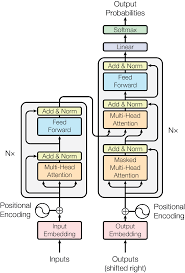

###Embedding Layers : Input Embedding and Output Embedding



It produces from a matrix (Number of Samples, Sequence Length) a matrix of shape (Number of Samples, Sequence Length, Embedding Size {d_model}) 

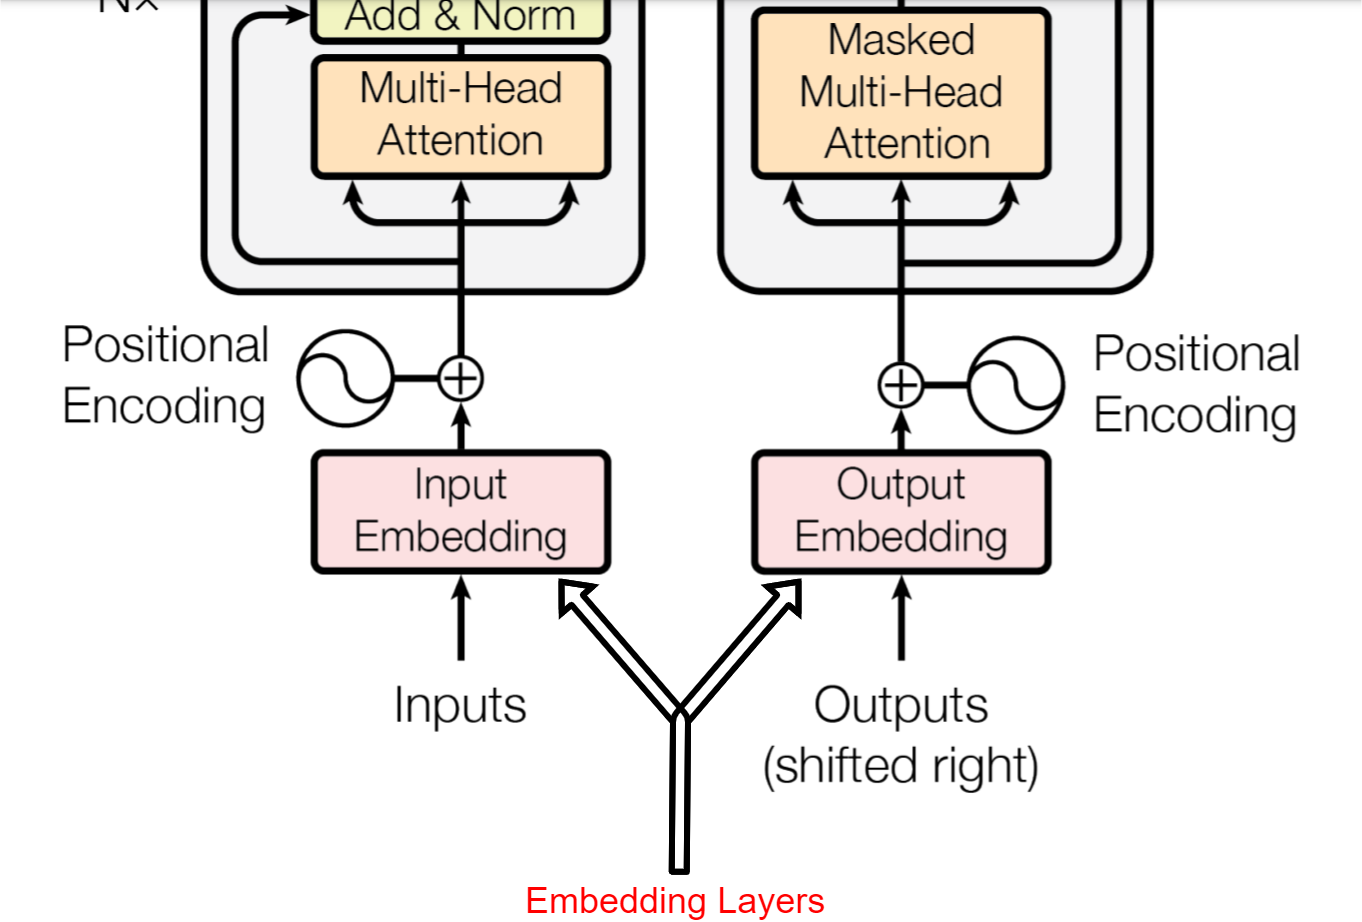

Embedding Layers learn an map which embed each word into a continuous vector space. This vector space representation allow us to have a continuous and distributed representation of the vocabulary words. This vocabulary words representation allow to create a distributed representation of sentences. In the process of training, this Deep Learning model learn this word embedding map. The hope is that by using a continuous representation, our embedding will map similar words to similar regions. 

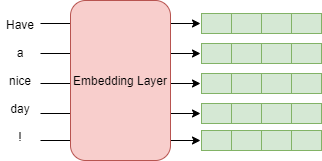

In [ ]:
class EmbeddingLayer(tf.keras.layers.Layer):
  """
  EmbeddingLayer produces from a 2D tensor with shape (Number of Samples,
  Sequence Length) a 3D tensor, a continuous and distributed representation of
  the vocabulary words with shape (Number of Samples, Sequence Length,
  Embedding Size {d_model})

  Parameters
  ----------
  sequence_length : int
      sequence_length is the length of the sentence.
  embedding_size : int, default 512
      embedding_size is the size to which the numbers (which were previously
      words) will be converted.
  
  Returns
  -------
  tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length, Embedding Size 
      {d_model}) representing sentences.
  """

  def __init__(self, sequence_length, embedding_size=512):
    self.sequence_length = sequence_length
    self.embedding_size = embedding_size
    super(EmbeddingLayer, self).__init__()
  
  def build(self, input_shape):
    self.embedding_layer = tf.keras.layers.Embedding(self.sequence_length,
                                                     self.embedding_size)
    super().build(input_shape)
  
  def call(self, inputs):
    embed = self.embedding_layer(inputs)
    return embed

###Positional Encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

###Linear Layer

Linear layers is composed by three fully connected layers to create a Query, a Key, and a Value. Each layer has its own weights. The input is passed through these fully connected layers to produce the Q, K, and V matrices.

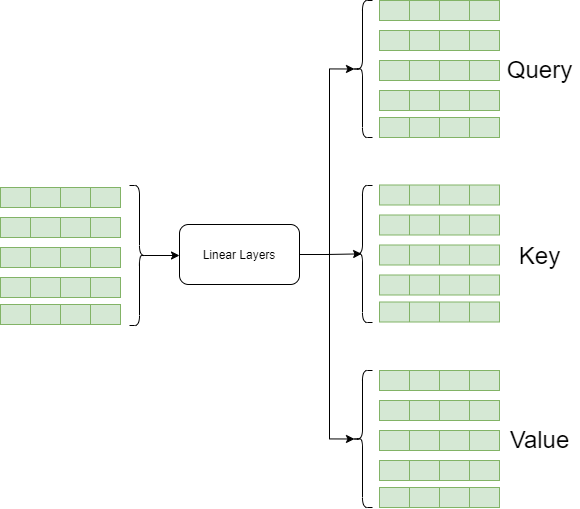

**What do the query, key and value represent?**

They can be seen as 3 entities of a search system.

Let's take Spotify as an example:
The query is the information we enter in the search bar.
The Key is made up of sets of information about each piece of music in the database (Title, Artist, album name, description, ...)
The Value is all the music in the database.

During a search, the system will map the query on each set of the key in order to propose the best matches: the musics (Value).

In [ ]:
class LinearLayers(tf.keras.layers.Layer):
  """
  Linear layers is composed by three fully connected layers to create a Query,
  a Key, and a Value. Each layer has its own weights. The input is passed
  through these fully connected layers to produce the Q, K, and V matrices.

  Parameters
  ----------
  x : tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length, Embedding Size 
      {d_model}) representing sentences.

  embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space
      of Q, K and V.
  
  Returns
  -------
  tf.Tensor
      a 4D tensor with shape (3, Number of Samples, Sequence Length,
      Embedding Size) composed by Q, V and K, each has a shape of (Number of
      Samples, Sequence Length, Embedding Size).
  """
  def __init__(self, embedding_size=512):
    self.embedding_size = embedding_size
    super(LinearLayers, self).__init__()

  def build(self, input_shape):
    self.Q_linear_layer = tf.keras.layers.Dense(self.embedding_size)
    self.K_linear_layer = tf.keras.layers.Dense(self.embedding_size)
    self.V_linear_layer = tf.keras.layers.Dense(self.embedding_size)
    super().build(input_shape)

  def call(self, x):
    Q = self.Q_linear_layer(x)
    K = self.K_linear_layer(x)
    V = self.V_linear_layer(x)
    return Q, K, V

In [ ]:
input_sentence = np.array([[0, 1, 2, 3, 4, 5, 6]])

def linear_layers_test(input_sentence):
  input_shape = input_sentence.shape[-1]

  input_layer = tf.keras.Input(shape=input_shape)
  embedding_layer = EmbeddingLayer(sequence_length=input_shape)(input_layer)
  linear_layers = LinearLayers()(embedding_layer)
  model = tf.keras.Model(input_layer, linear_layers)
  
  Q, K, V = model(input_sentence)
  tf.ensure_shape(Q, [1, 7, 512])
  tf.ensure_shape(K, [1, 7, 512])
  tf.ensure_shape(V, [1, 7, 512])
  return model


model = linear_layers_test(input_sentence)
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
embedding_layer_7 (Embedding (None, 7, 512)            3584      
_________________________________________________________________
linear_layers_19 (LinearLaye ((None, 7, 512), (None, 7 787968    
Total params: 791,552
Trainable params: 791,552
Non-trainable params: 0
_________________________________________________________________


###Multi-Head Attention

In a multi-head attention computation, query, key, and value are split into N vectors. Attention are apply on each vectors via a Head Attention. Multi-head attention is used to give to the encoder and decoder model more representation power because in theory each head allows to characterise different relationships between tokens (words).

####Splitting data across Attention heads

This step allow to split query, key and value into nb_heads vectors, generaly they are split into 8 vectors.

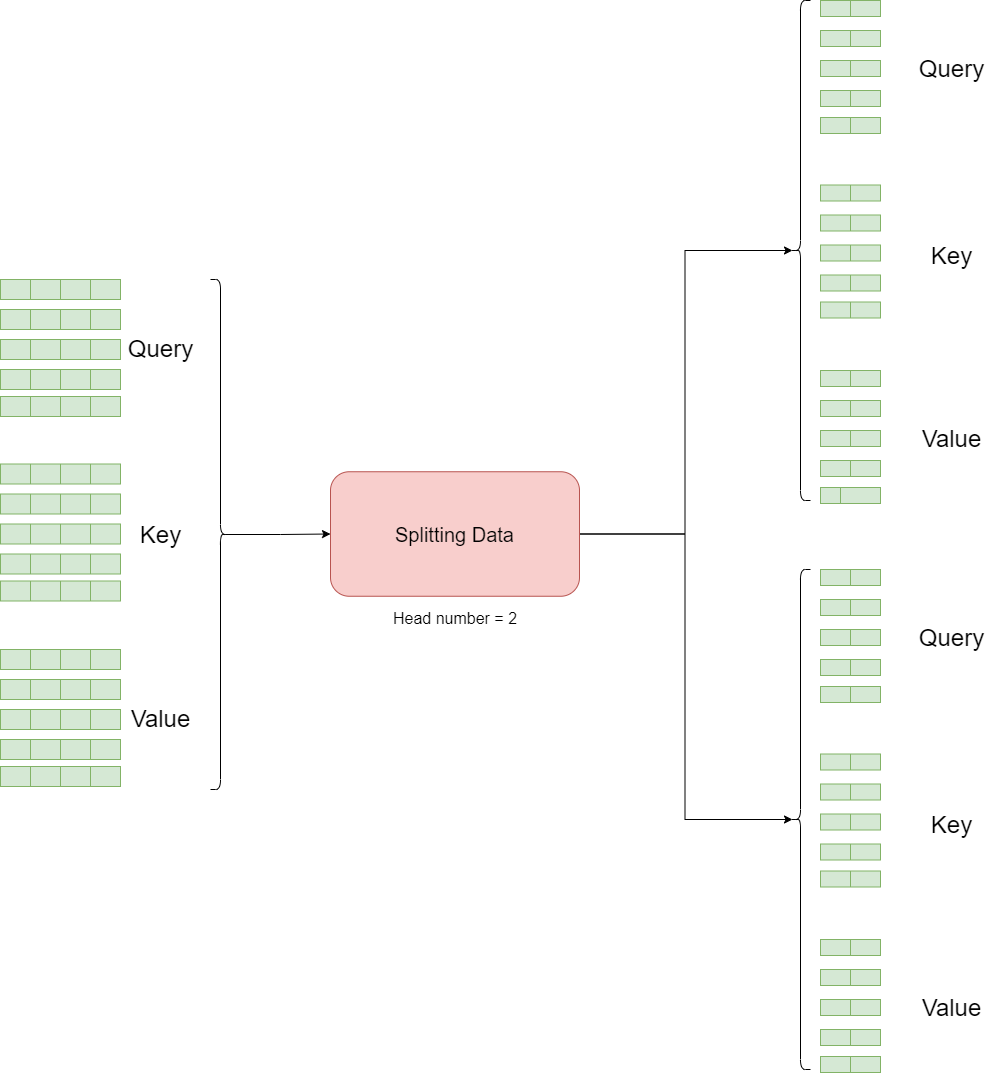

In [ ]:
def splitting_data_across_attention_heads(x, embedding_size=512, nb_heads=8):
    """
    Splitting data across attention heads allow to split query, key and value
    into N vectors, generaly they are split into 8 vectors.

    Parameters
    ----------
    x : tf.Tensor
        a 4D tensor with shape (3, Number of Samples, Sequence Length,
        Embedding Size) composed by Q, V and K, each has a shape of (Number of
        Samples, Sequence Length, Embedding Size).

    embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space
      of Q, K and V.

    nb_heads : int, default 8
        a integer representing heads number, the 4D tensor x is split into
        nb_heads Vectors.
    
    Returns
    -------
    tf.Tensor
        a 3D tensor with shape (Number of Samples * Number of Heads,
        Sequence Length, Head Size).
    """
    batch_size = tf.shape(x)[0]
    nb_tokens = tf.shape(x)[1]
    head_size = embedding_size // nb_heads

    x = tf.reshape(x, [batch_size, nb_tokens, nb_heads, head_size])
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [batch_size * nb_heads, nb_tokens, head_size])
    return x

In [ ]:
Q_split = tf.ensure_shape(splitting_data_across_attention_heads(Q), [8, 7, 64])

####Scaled Dot Product Attention


####Scaled Dot Product Attention

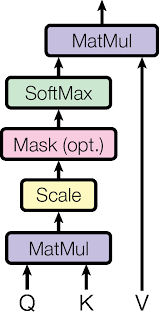

The scaled Dot-Product Attention is the attention function used by the transformer to calculate the attention weights. The function takes as input 3 elements: A Query (Q), a Key (K) and a Value (V).
Here is the attention equation in mathematical form:
\begin{equation*}
Attention(Q, K, V) = softmax(QK^T / \sqrt N)\cdot V
\end{equation*}

Queries, keys and values are representations of the hidden states of the encoder and decoder of a transformer. They are used to retrieve information within the attention layer by calculating the similarity between the decoder queries and the encoder keys. The similarity is calculated by the dot product between the query and the key. Indeed, the dot product of two similar vectors tends to have a higher value.

The score matrix determines how much focus should a word be put on other words. The higher the score the more focus.

\begin{equation*}
Q\cdot K^T = Score
\end{equation*}

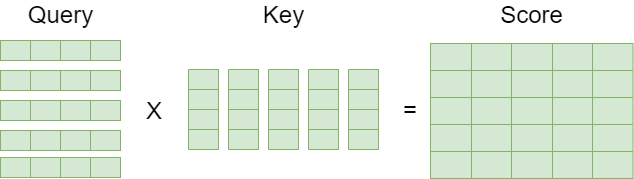


The scaled Dot product Attention is a Dot product Attention that we scaled down by dividing $Q\cdot K^T$ by the square root of the depth of Q (We could use K instead of Q, they have the same shapes).
The reason for doing this scaled is that we assume that Q and K have components which are random variables of mean 0 and variance 1.

Thus, $q\cdot k = \sum_{i=1}^N q^ik^i$ has a mean of 0 and a variance of N. However, we prefer to have a variance of 1 when applying the softmax. The dot product between the query and the key is then divided by N.
The scaling is performed so that the arguments of the softmax function do not become excessively large with query and a key of higher dimensions.




The weighted sum at each value is determined by the probability that the key matches the query. This probability is determined by applying a softmax (distribution between 0 and 1).


Attention weights = $softmax(QK^T / \sqrt N)$


Weighted Value = Attention weights $\cdot V$

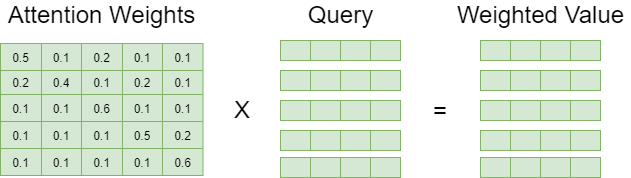


A mask is used to prevent the attention mechanism to share any information regarding the token at the next positions, when giving a prediction using all the previous tokens.

In [ ]:
def get_mask(matrix_shape):
  mask = tf.sequence_mask(tf.range(matrix_shape[1]), matrix_shape[2])
  mask = tf.cast(mask, tf.float32)
  mask = tf.expand_dims(mask, axis=0)
  mask = tf.repeat(mask, repeats=[matrix_shape[0]], axis=0)
  return mask

mask = get_mask((8, 7, 64))
mask 

<tf.Tensor: shape=(8, 7, 64), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1.

In [ ]:
(Q_split * mask)[0,:,:]

<tf.Tensor: shape=(7, 64), dtype=float32, numpy=
array([[ 0.        , -0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
         0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        ,  0.        ,  0.        , -0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        , -0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        ],
       [-0.015

In [ ]:
def scaled_dot_product_attention(Q, K, V, if_mask=False):
  """
  The scaled Dot-Product Attention is the attention function used by the
  transformer to calculate the attention weights.

  Parameters
  ----------
  Q : tf.Tensor
      a 3D Tensor representing Query.

  K : tf.Tensor
      a 3D Tensor representing Key.

  V : tf.Tensor
      a 3D Tensor representing Value.

  if_mask : bool, default False
      Whether to hide next elements.
  
  Returns
  -------
  tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length, Embedding Size)
      representing weighted value.
  """
  QK = tf.matmul(Q, K, transpose_b=True)
  QK_scale = QK / tf.math.sqrt(float(tf.shape(Q)[-1]))

  if if_mask:
    mask = get_mask(tf.shape(QK_scale))
    softmax = tf.nn.softmax(QK_scale * mask)
  else:
    softmax = tf.nn.softmax(QK_scale)

  weighted_value = tf.matmul(softmax, V)
  return weighted_value

####Concatenating Data

This step consists in concatenating all the attention weights coming out of each attention head into a single tensor.

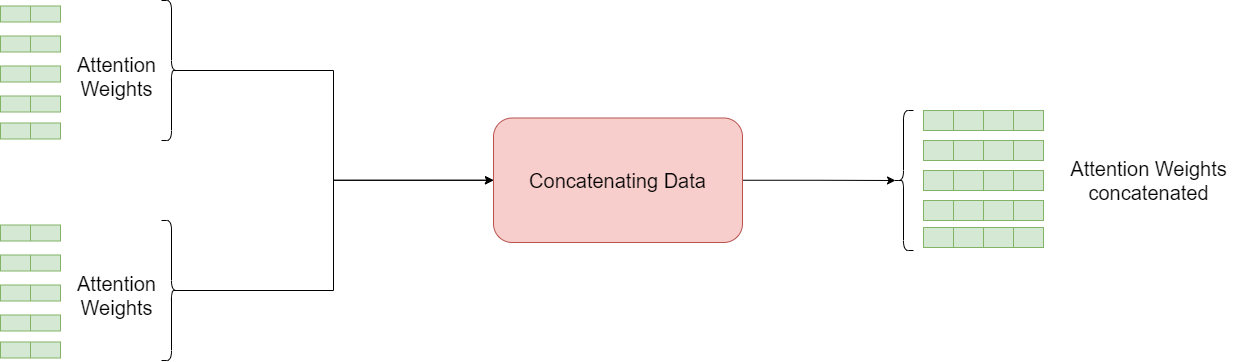

In [ ]:
def concat_layers(x, embedding_size=512, nb_heads=8):
  """
  The concat layers concatenate all the attention weights coming out of each 
  attention head into a single tensor.

  Parameters
  ----------
  x : tf.Tensor
      a 4D Tensor composed by multiple Attention Weights.

  embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space
      of Attention Weights concatanated.

  nb_heads : int, default 8
      a integer representing heads number, the 4D tensor x is split into
      nb_heads Vectors.

  Returns
  -------
  tf.Tensor
      a 4D tensor with shape (Number of Samples, Sequence Length,
      Number of Heads * Head Size) representing Attention Weights concatenated.
  """
  batch_size = tf.shape(x)[0] // nb_heads
  nb_tokens = tf.shape(x)[1]
  head_size = embedding_size // nb_heads

  x = tf.reshape(x, [batch_size, nb_heads, nb_tokens, head_size])
  x = tf.transpose(x, perm=[0, 2, 1, 3])
  x = tf.reshape(x, [batch_size, nb_tokens, nb_heads * head_size])
  return x

In [ ]:
input_sentence = np.array([[0, 1, 2, 3, 4, 5, 6]])

def concat_test(x):
  linear_layers = linear_layers_test(x.shape[-1])
  Q, K, V = linear_layers(x)

  Q_split = splitting_data_across_attention_heads(Q)
  K_split = splitting_data_across_attention_heads(K)
  V_split = splitting_data_across_attention_heads(V)

  assert(Q_split.shape == (8, 7, 64))
  attention = scaled_dot_product_attention(Q_split, K_split, V_split, True)
  assert(attention.shape == (8, 7, 64))
  attention = concat_layers(attention)
  assert(attention.shape == (1, 7, 512))

concat_test(input_sentence)

####Multi-Head Attention

Multi-Head Attention is a module composed of the 4 previous entities, cad Splitting Data, Scaled Dot Product Attention, Concatenating Data and Output Linear Layers.
Its aim in the transformer network is to compute for a input the attention weights and to create an output vector containing encoded information on how each word should attend to all other words in the sequence.

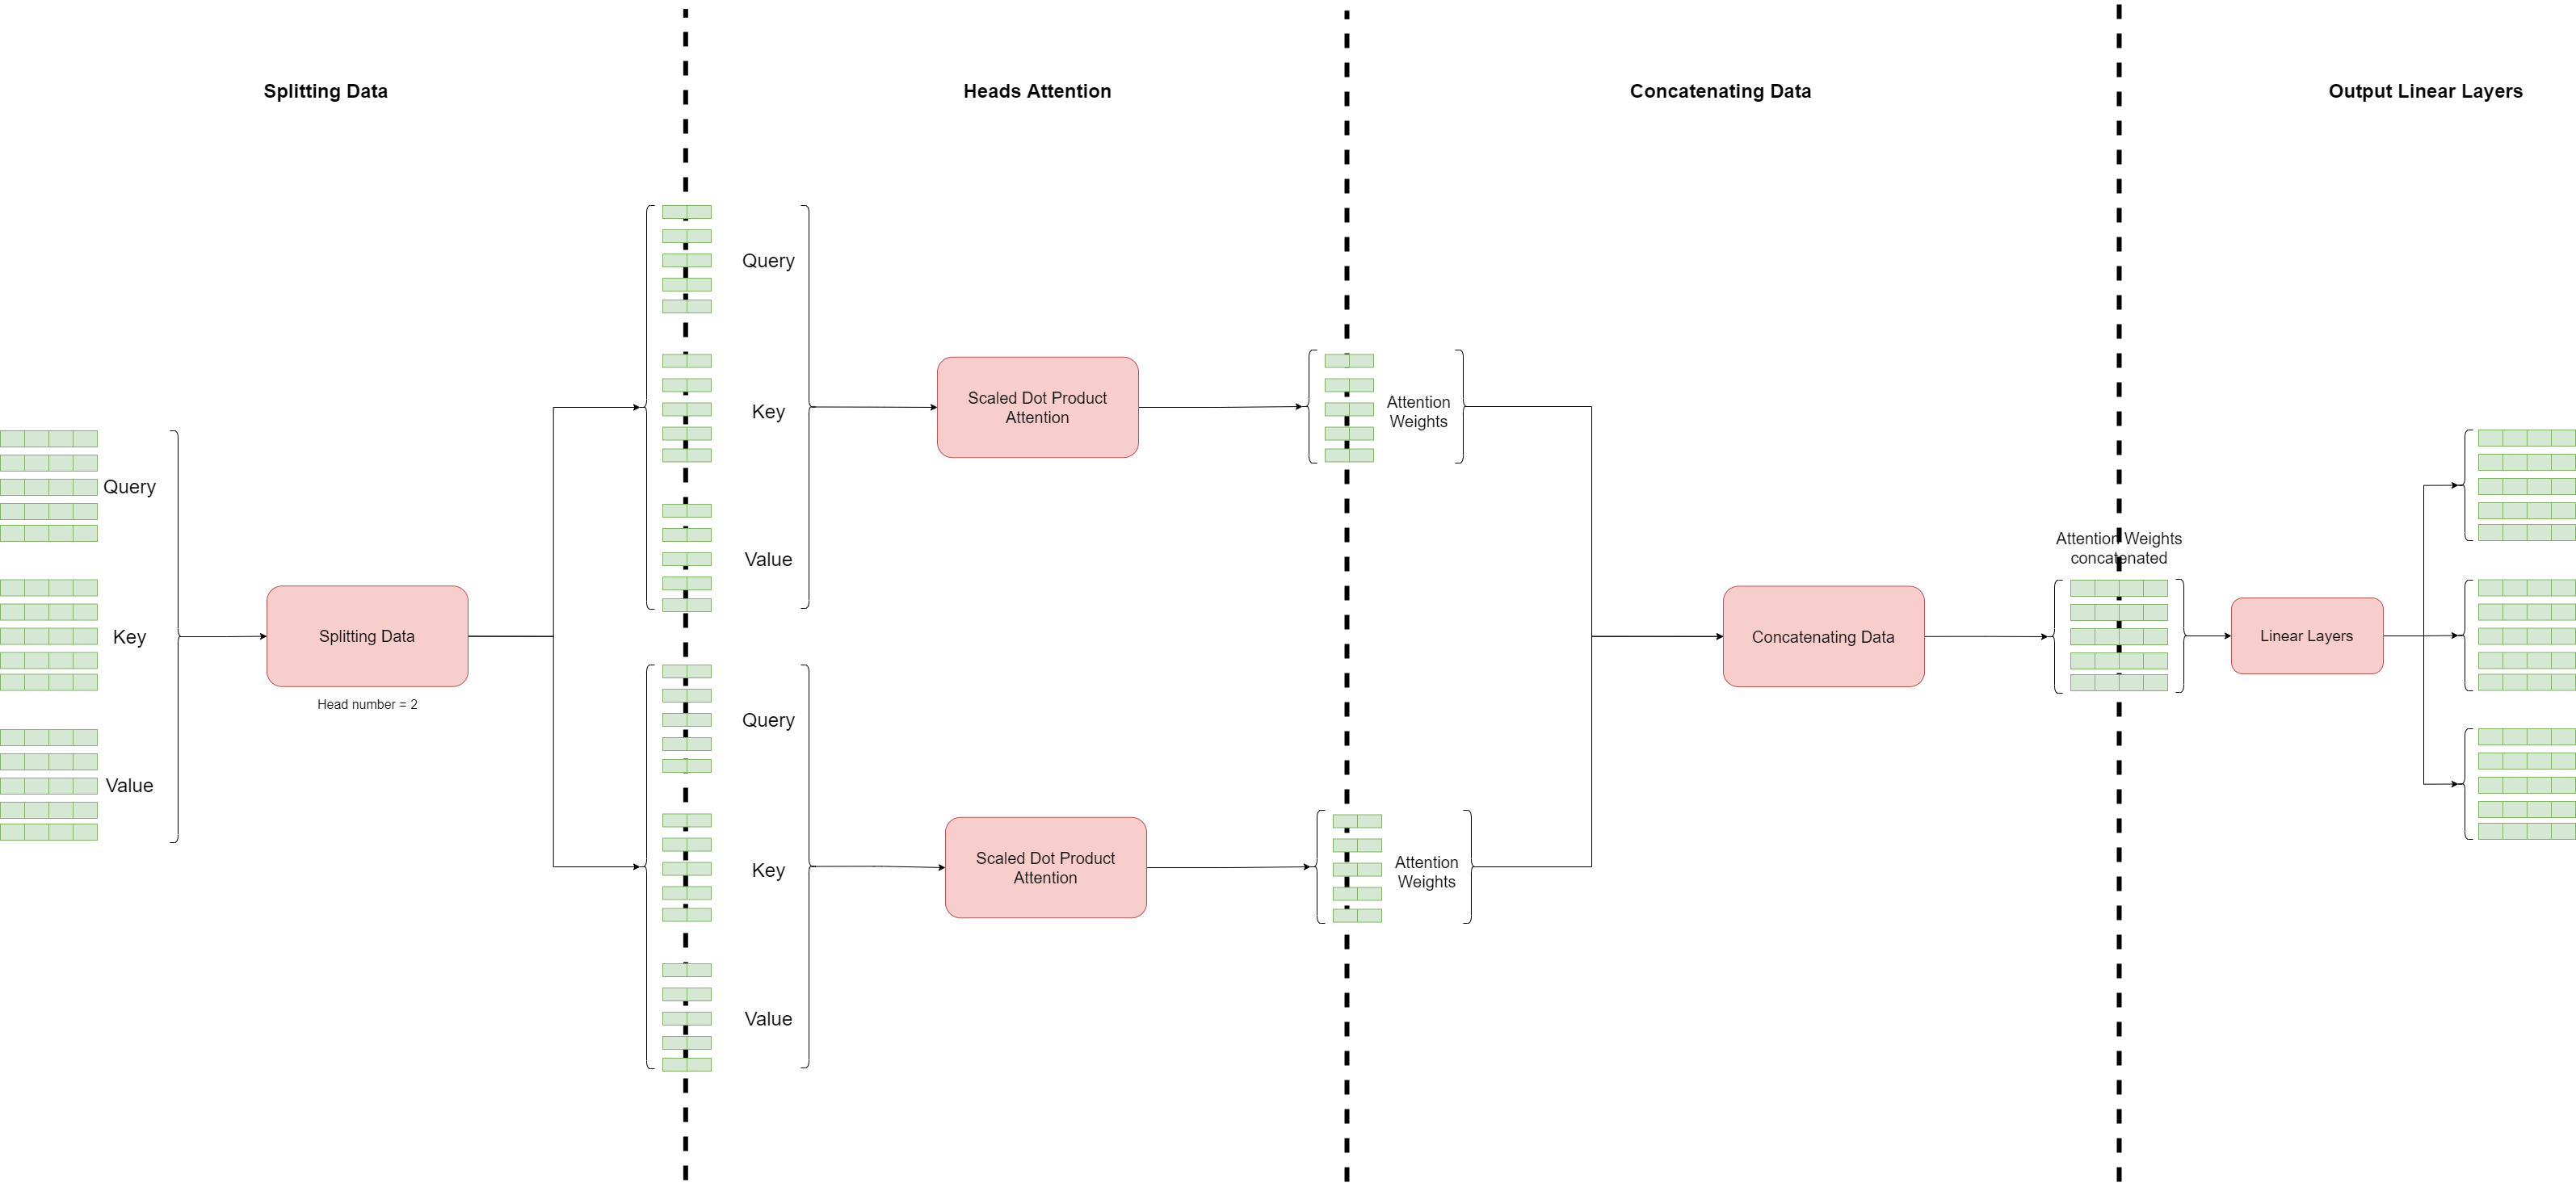

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  """
  Multi-Head Attention is a module composed of the 4 previous entities, cad
  Splitting Data, Scaled Dot Product Attention, Concatenating Data and Output
  Linear Layers.
  Its aim in the transformer network is to compute for a input the attention
  weights and to create an output vector containing encoded information on how
  each word should attend to all other words in the sequence.

  Parameters
  ----------
  x : tf.Tensor
      a 4D tensor with shape (3, Number of Samples, Sequence Length,
      Embedding Size) composed by Q, V and K, each has a shape of (Number of
      Samples, Sequence Length, Embedding Size).


  embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space
      of Attention Weights concatanated.

  nb_heads : int, default 8
      a integer representing heads number, the 4D tensor x is split into
      nb_heads Vectors.
    
  if_mask : bool, default False
      Whether to hide next elements.

  Returns
  -------
  tf.Tensor
      a 4D tensor with shape (3, Number of Samples, Sequence Length,
      Embedding Size) containing encoded information on how each word should
      attend to all other words in the sequence.
  """
  def __init__(self, embedding_size=512, nb_heads=8, if_mask=False):
    self.embedding_size = embedding_size
    self.nb_heads = nb_heads
    self.if_mask = if_mask
    super(MultiHeadAttention, self).__init__()

  def build(self, input_shape):
    self.output_linear_layers = tf.keras.layers.Dense(self.embedding_size)
    super().build(input_shape)

  def call(self, x):
    Q, K, V = x

    Q_split = splitting_data_across_attention_heads(Q, self.embedding_size, self.nb_heads)
    K_split = splitting_data_across_attention_heads(K, self.embedding_size, self.nb_heads)
    V_split = splitting_data_across_attention_heads(V, self.embedding_size, self.nb_heads)

    attention = scaled_dot_product_attention(Q_split, K_split, V_split, self.if_mask)
    attention = concat_layers(attention, self.embedding_size, self.nb_heads)
    output_attention = self.output_linear_layers(attention)
    return output_attention

In [ ]:
def multi_head_attention_test(x):
  input_shape = x.shape[-1]

  input_layer = tf.keras.Input(shape=input_shape)
  embedding_layer = EmbeddingLayer(sequence_length=input_shape)(input_layer)
  linear_layers = LinearLayers()(embedding_layer)
  multi_head_attention = MultiHeadAttention()(linear_layers)
  
  model = tf.keras.Model(input_layer, multi_head_attention)
  output_attention = model(input_sentence)
  tf.ensure_shape(output_attention, [1, 7, 512])
  return model

input_sentence = np.array([[0, 1, 2, 3, 4, 5, 6]])
model = multi_head_attention_test(input_sentence)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
embedding_layer_8 (EmbeddingLay (None, 7, 512)       3584        input_10[0][0]                   
__________________________________________________________________________________________________
linear_layers_20 (LinearLayers) ((None, 7, 512), (No 787968      embedding_layer_8[0][0]          
__________________________________________________________________________________________________
multi_head_attention_19 (MultiH (None, None, 512)    262656      linear_layers_20[0][0]           
                                                                 linear_layers_20[0][1]     

###Feed-Forward Layers

The Feed-Forward Layers is composed by two linear layers with a ReLU activation in between.

In [ ]:
class FeedForwardLayers(tf.keras.layers.Layer):
  """
  Feed-Forward Layers is composed by two linear layers with a ReLU activation in
  between.

  Parameters
  ----------
  x : tf.Tensor
      a 4D tensor with shape (Number of Samples, Sequence Length,
      Number of Heads * Head Size) representing Attention Weights.
  
  inner_layer_size : int, default 2048
      Inner layer size is a positive integer, dimensionality of the inner output
      space.
  
  embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space.

  Returns
  -------
  tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length,
      Number of Heads * Head Size) representing Attention Weights.
  """

  def __init__(self, inner_layer_size=2048, embedding_size=512):
    self.inner_layer_size = inner_layer_size
    self.embedding_size = embedding_size
    super(FeedForwardLayers, self).__init__()

  def build(self, input_shape):
    self.input_dense = tf.keras.layers.Dense(self.inner_layer_size, 
                                             activation='relu')
    self.output_dense = tf.keras.layers.Dense(self.embedding_size)
    super().build(input_shape)

  def call(self, x):
    x = self.input_dense(x)
    x = self.output_dense(x)
    return x

#Encoder / Decoder

Transformer is built in layers in both its encoding and decoding parts (6 encoding layers and 6 decoding layers). Each layer (each Decoder) learning particular characteristics which it then provides to the following layer (note: this number of 6 is not magic: it is more a compromise to have an acceptable training time according to the computation possibilities of the time). Now in February 2020 we have 78 layers for Turing-NLG

-> works in the same way as convolutions in a row

##Encoder Layer

The Encoder layers goal is to map inputs sequences into an abstract continuous representation containing the learned information about input sequence.

The Encoder layers is composed by:
1. Linear Layers to create a Query, a Key and a Value.
2. Multi-Head Attention to create an output vector containing encoded information on how each word should attend to all other words in the sequence.
3. Dropout ignoring neurons during the training phase to prevent overfitting
4. Add (skip connection) and normalisation to reduce training time and the vanishing gradiant.
5. Feed Forward
6. Dropout ignoring neurons during the training phase to prevent overfitting
7. Add (skip connection) and normalisation to reduce training time and the vanishing gradiant.

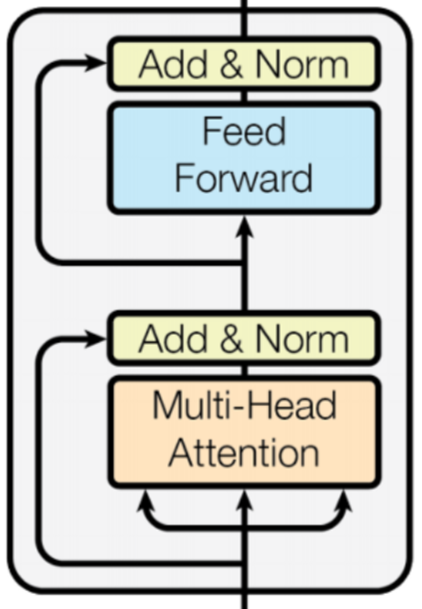

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  """
  The Encoder layers goal is to map inputs sequences into an abstract continuous
  representation containing the learned information about input sequence.

  Parameters
  ----------
  x : tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length, Embedding Size 
      {d_model}) representing sentences.
  
  embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space.

  inner_layer_size : int, default 2048
      Inner Layer Size is a positive integer, dimensionality of the first Dense
      output space.

  nb_heads : int, default 8
      a integer representing heads number, the 4D tensor x is split into
      nb_heads Vectors.
  
  dropout_rate : int, default 0.1
      Dropout rate is set to N, meaning one in 1 / N inputs will be randomly
      excluded from each update cycle.

  training : bool, default True
      Whether to train layers.

  Returns
  -------
  tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length,
      Number of Heads * Head Size) representing Attention Weights.
  """

  def __init__(self, embedding_size=512, nb_heads=8, inner_layer_size=2048,
               dropout_rate=0.1):
    self.embedding_size = embedding_size
    self.nb_heads = nb_heads
    self.inner_layer_size = inner_layer_size
    self.dropout_rate = dropout_rate
    super(EncoderLayer, self).__init__()

  def build(self, input_shape):
    self.linear_layers = LinearLayers(self.embedding_size)
    self.multi_head_attention = MultiHeadAttention(self.embedding_size, 
                                                   self.nb_heads)
    self.post_attention_normalization = tf.keras.layers.LayerNormalization()
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.feed_forward_layers = FeedForwardLayers(inner_layer_size=self.inner_layer_size,
                                                 embedding_size=self.embedding_size)
    self.post_feed_forward_normalization = tf.keras.layers.LayerNormalization()
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    super().build(input_shape)

  def call(self, x, training=True):
    query_key_value = self.linear_layers(x)
    
    attention = self.multi_head_attention(query_key_value)
    attention = self.dropout1(attention, training=training)
    normalized_attention = self.post_attention_normalization(attention + x)

    output = self.feed_forward_layers(normalized_attention)
    output = self.dropout2(output, training=training)
    normalized_output = self.post_feed_forward_normalization(output +
                                                             normalized_attention)
    return normalized_output


##Encoder

Each encoder has 8 heads, each of which characterises different relationships between tokens (analogy with parallel convolutions in InceptionV1 networks)

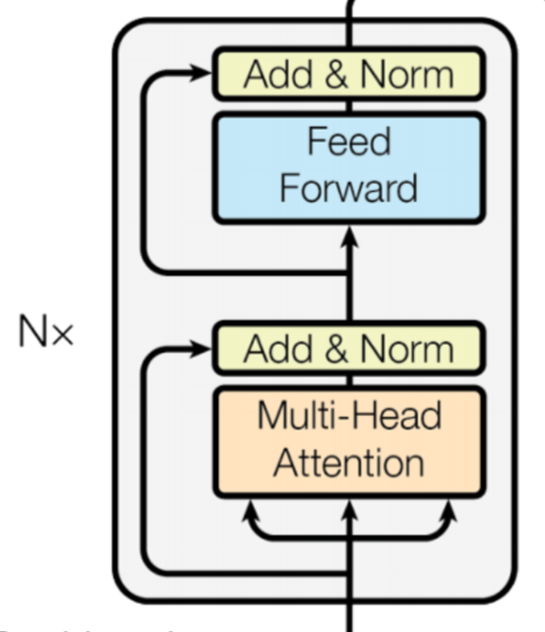

In [ ]:
class Encoder(tf.keras.layers.Layer):
  """
  The Encoder is composed by nb_encoder_layers consecutive Encoder Layers and
  its aim is to map inputs sequences into an abstract continuous representation
  containing the learned information about input sequence.

  Parameters
  ----------
  x : tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length, Embedding Size 
      {d_model}) representing sentences.

  vocab_size : int
      a integer representing the vocabulary size of the input x.
  
  maximum_position_encoding : int

  nb_encoder_layers : int, default 6
      a integer representing the number of encoders layers that follow each
      other in the Encoder.
  
  embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space.

  nb_heads : int, default 8
      a integer representing heads number, the 4D tensor x is split into
      nb_heads Vectors.

  inner_layer_size : int, default 2048
      Inner Layer Size is a positive integer, dimensionality of the first Dense
      output space.

  dropout_rate : int, default 0.1
      Dropout rate is set to N, meaning one in 1 / N inputs will be randomly
      excluded from each update cycle.

  training : bool, default True
      Whether to train layers.

  Returns
  -------
  tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length,
      Number of Heads * Head Size) representing Attention Weights.
  """
  def __init__(self, vocab_size, maximum_position_encoding, nb_encoder_layers=6,
               embedding_size=512, nb_heads=8, inner_layer_size=2048,
               dropout_rate=0.1):
    self.vocab_size=vocab_size
    self.maximum_position_encoding=maximum_position_encoding
    self.nb_encoder_layers = nb_encoder_layers
    self.embedding_size = embedding_size
    self.nb_heads = nb_heads
    self.inner_layer_size = inner_layer_size
    self.dropout_rate = dropout_rate
    super(Encoder, self).__init__()
  
  def build(self, input_shape):
    self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size,
                                                     self.embedding_size)
    self.positional_encoding = positional_encoding(self.maximum_position_encoding,
                                                   self.embedding_size)
    self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.encoder_layers = []
    for _ in range(self.nb_encoder_layers):
      self.encoder_layers.append(EncoderLayer(self.embedding_size,
                                              self.nb_heads,
                                              self.inner_layer_size,
                                              self.dropout_rate))
    super().build(input_shape)

  def call(self, x, training=True):
    seq_len = tf.shape(x)[1]

    x = self.embedding_layer(x)
    x *= tf.math.sqrt(tf.cast(self.embedding_size, tf.float32))
    x += self.positional_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    for encoder in self.encoder_layers:
      x = encoder(x, training)
    return x

In [ ]:
def encoder_test(input):
  input_shape = input.shape[-1]

  input_layer = tf.keras.Input(shape=input_shape)
  encoder_layers = Encoder(input_shape, 10000, embedding_size=512)(input_layer)
  model = tf.keras.Model(input_layer, encoder_layers)
  return model

input_sentence = np.array([[0, 1, 2, 3, 4]])
model = encoder_test(input_sentence)
model.summary()
encoder_output= model(input_sentence)
print(encoder_output.shape)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
encoder (Encoder)            (None, 5, 512)            18916864  
Total params: 18,916,864
Trainable params: 18,916,864
Non-trainable params: 0
_________________________________________________________________
(1, 5, 512)


##Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  """
  The Decoder layers goal is to predict the next word by looking at the encoder
  output and self-attending to its own output.
  As Q receives the output from decoder's first attention block, and K receives
  the encoder output, the attention weights represent the importance given to
  the decoder's input based on the encoder's output.

  Parameters
  ----------
  x : tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length, Embedding Size 
      {d_model}) representing sentences.
  
  embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space.

  nb_heads : int, default 8
      a integer representing heads number, the 4D tensor x is split into
      nb_heads Vectors.

  inner_layer_size : int, default 2048
      Inner Layer Size is a positive integer, dimensionality of the first Dense
      output space.
  
  dropout_rate : int, default 0.1
      Dropout rate is set to N, meaning one in 1 / N inputs will be randomly
      excluded from each update cycle.

  training : bool, default True
      Whether to train layers.

  Returns
  -------
  tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length,
      Number of Heads * Head Size) representing Attention Weights.
  """
  def __init__(self, embedding_size=512, nb_heads=8, inner_layer_size=2048,
               dropout_rate=0.1):
    self.embedding_size = embedding_size
    self.nb_heads = nb_heads
    self.inner_layer_size = inner_layer_size
    self.dropout_rate = dropout_rate
    super(DecoderLayer, self).__init__()

  def build(self, input_shape):
    self.linear_layers = LinearLayers(self.embedding_size)
    self.masked_multi_head_attention = MultiHeadAttention(self.embedding_size, 
                                                   self.nb_heads,
                                                   True)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.first_post_attention_normalization = tf.keras.layers.LayerNormalization()
    self.multi_head_attention = MultiHeadAttention(self.embedding_size, 
                                                   self.nb_heads)
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.second_post_attention_normalization = tf.keras.layers.LayerNormalization()
    self.feed_forward_layers = FeedForwardLayers(inner_layer_size=self.inner_layer_size,
                                                 embedding_size=self.embedding_size)
    self.dropout3 = tf.keras.layers.Dropout(self.dropout_rate)
    self.post_feed_forward_normalization = tf.keras.layers.LayerNormalization()
    super().build(input_shape)

  def call(self, x, training=True):
    encoder_output, output_embedding = x

    query_key_value = self.linear_layers(output_embedding)
    query = self.masked_multi_head_attention(query_key_value)
    query = self.dropout1(query, training=training)
    normalized_query = self.first_post_attention_normalization(query +
                                                             output_embedding)
    attention = self.multi_head_attention((normalized_query, encoder_output,
                                                  encoder_output))
    attention = self.dropout2(attention, training=training)
    normalized_attention = self.second_post_attention_normalization(attention +
                                                             normalized_query)

    output = self.feed_forward_layers(normalized_attention)
    output = self.dropout3(output, training=training)
    normalized_output = self.post_feed_forward_normalization(output +
                                                             normalized_attention)
    return normalized_output

##Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  """
  The Decoder is composed by nb_encoder_layers consecutive Decoder Layers and
  its aim is to predict the next word by looking at the encoder output and
  self-attending to its own output.
  As Q receives the output from decoder's first attention block, and K receives
  the encoder output, the attention weights represent the importance given to
  the decoder's input based on the encoder's output.

  Parameters
  ----------
  encoder_output : tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length,
      Number of Heads * Head Size) representing Input Attention Weights.
  
  output : tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length, Embedding Size 
      {d_model}) representing sentences.

  vocab_size : int
      a integer representing the vocabulary size of the input x.
  
  maximum_position_encoding : int

  nb_encoder_layers : int, default 6
      a integer representing the number of encoders layers that follow each
      other in the Encoder.
  
  embedding_size : int, default 512
      Embedding Size is a positive integer, dimensionality of the output space.

  nb_heads : int, default 8
      a integer representing heads number, the 4D tensor x is split into
      nb_heads Vectors.

  inner_layer_size : int, default 2048
      Inner Layer Size is a positive integer, dimensionality of the first Dense
      output space.

  dropout_rate : int, default 0.1
      Dropout rate is set to N, meaning one in 1 / N inputs will be randomly
      excluded from each update cycle.

  training : bool, default True
      Whether to train layers.

  Returns
  -------
  tf.Tensor
      a 3D tensor with shape (Number of Samples, Sequence Length,
      Number of Heads * Head Size) representing Attention Weights.
  """
  def __init__(self, vocab_size, maximum_position_encoding, nb_decoder_layers=6,
               embedding_size=512, nb_heads=8, inner_layer_size=2048,
               dropout_rate=0.1):
    self.vocab_size = vocab_size
    self.maximum_position_encoding = maximum_position_encoding
    self.nb_decoder_layers = nb_decoder_layers
    self.embedding_size = embedding_size
    self.nb_heads = nb_heads
    self.inner_layer_size = inner_layer_size
    self.dropout_rate = dropout_rate
    super(Decoder, self).__init__()
  
  def build(self, input_shape):
    self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size,
                                                     self.embedding_size)
    self.positional_encoding = positional_encoding(self.maximum_position_encoding,
                                                   self.embedding_size)
    self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.decoder_layers = []
    for _ in range(self.nb_decoder_layers):
      self.decoder_layers.append(DecoderLayer(self.embedding_size,
                                              self.nb_heads,
                                              self.inner_layer_size,
                                              self.dropout_rate))
    super().build(input_shape)

  def call(self, encoder_output, output, training=True):
    seq_len = tf.shape(output)[1]

    output_embedding = self.embedding_layer(output)
    output_embedding *= tf.math.sqrt(tf.cast(self.embedding_size, tf.float32))
    output_embedding += self.positional_encoding[:, :seq_len, :]

    output_embedding = self.dropout(output_embedding, training=training)
    for decoder in self.decoder_layers:
      output_embedding = decoder((encoder_output, output_embedding), training)
    return output_embedding

#Transformer

In [ ]:
class Transformer(tf.keras.Model):
  
  def __init__(self, input_vocab_size, output_vocab_size, pos_input, pos_output,
               nb_layers=6, embedding_size=512, nb_heads=8,
               inner_layer_size=2048, dropout_rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(input_vocab_size, pos_input, nb_layers,
                           embedding_size, nb_heads, inner_layer_size,
                           dropout_rate)
    self.decoder = Decoder(output_vocab_size, pos_output, nb_layers,
                           embedding_size, nb_heads, inner_layer_size,
                           dropout_rate)
    self.final_layer = tf.keras.layers.Dense(output_vocab_size)

  def call(self, input_sentence, output_sentence, training=True):
    encoder_output = self.encoder(input_sentence, training)
    decoder_output = self.decoder(encoder_output, output_sentence, training)
    final_output = self.final_layer(decoder_output)
    return final_output

In [ ]:
input = [['Quel', 'temps', 'fait', 'il', '?'], ['Bonne', 'journée', '!']]
output = [['<start>', 'What', 'is', 'the', 'weather', 'like', '?'],
          ['Have', 'a', 'nice', 'day', '!']]

input_seqs = tokenizer(texts=input)
output_seqs = tokenizer(texts=output)

model = Transformer(8000, 8000, 10000, 10000)
output = model(input_seqs, output_seqs)
model.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  23010304  
_________________________________________________________________
decoder (Decoder)            multiple                  24592384  
_________________________________________________________________
dense (Dense)                multiple                  4104000   
Total params: 51,706,688
Trainable params: 51,706,688
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_seqs

array([[2, 3, 4, 5, 6],
       [7, 8, 9, 0, 0]], dtype=int32)

In [ ]:
output_seqs

array([[ 2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13,  0,  0]], dtype=int32)

In [ ]:
output

<tf.Tensor: shape=(2, 7, 8000), dtype=float32, numpy=
array([[[-2.8859934e-01, -6.8225414e-01,  4.3735072e-02, ...,
          2.6866853e-02, -1.9480583e-01, -5.4400593e-01],
        [-2.3986468e-01, -7.7203321e-01,  4.0640682e-02, ...,
          1.1023650e-01, -2.6200664e-01, -4.3063208e-01],
        [-3.3710539e-01, -6.6256380e-01, -1.1144355e-01, ...,
          2.6029828e-01, -3.7992924e-01, -8.0094767e-01],
        ...,
        [-2.6863796e-01, -4.5861283e-01, -1.4757630e-01, ...,
          1.9391446e-01, -2.8840739e-01, -6.2068325e-01],
        [-1.6331589e-01, -6.0703164e-01,  8.5456759e-02, ...,
          1.0406584e-01, -1.8225589e-01, -5.5990547e-01],
        [-2.3738246e-01, -4.3275395e-01,  1.0656160e-01, ...,
          1.0487929e-01, -2.8822497e-01, -6.8973625e-01]],

       [[ 1.5265419e-01, -9.2782122e-01,  9.7262979e-02, ...,
          1.9601892e-01, -1.4990845e-01, -6.8376493e-01],
        [ 2.1398652e-01, -8.7377024e-01, -5.6909710e-02, ...,
          5.6111272e-02, -7.4